     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 2.7 MB/s eta 0:00:00


Saving Adcock-2010_with_serial_numbers.csv to Adcock-2010_with_serial_numbers.csv
Calculated values: a = 15.571324397686197, b = 12979.478977130508, c = 4.550097964639358


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

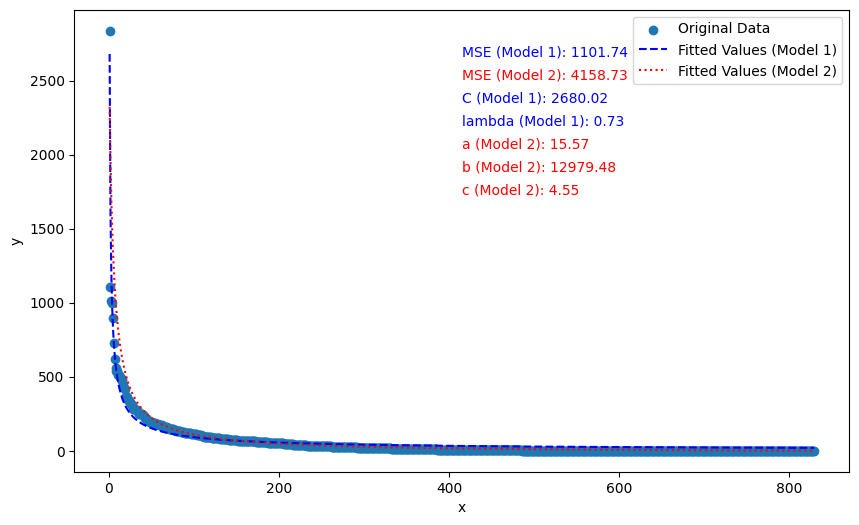

In [1]:
!pip install python-docx
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from google.colab import files
from docx import Document
from docx.shared import Inches

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

x_data = data['Serial Number'].values
y_data = data['Cites'].values

def calculate_h_index(y_data):
    sorted_cites = np.sort(y_data)[::-1]
    h_index = np.max(np.where(sorted_cites >= np.arange(1, len(sorted_cites) + 1))[0]) + 1
    return h_index

h = calculate_h_index(y_data)
M = max(y_data)
N = len(y_data)

a = (M * h**2) / (M * N - (M + N) * h)
b = (M * N * (M - h) * (N - h)) * (h / (M * N - (M + N) * h))**2
c = (N * h**2) / (M * N - (M + N) * h)

print(f'Calculated values: a = {a}, b = {b}, c = {c}')

def equation(params, x):
    C, lam = params
    return C / (x ** lam)

def mse_loss(params, x, y):
    y_pred = equation(params, x)
    return np.mean((y - y_pred) ** 2)

initial_params = [M, 1.0]

result = minimize(mse_loss, initial_params, args=(x_data, y_data), bounds=[(0, None), (0, None)])
C_opt, lam_opt = result.x

fitted_values = equation([C_opt, lam_opt], x_data)
mse1 = mse_loss([C_opt, lam_opt], x_data, y_data)

data['fitted1'] = fitted_values
data['C1'] = C_opt
data['lambda1'] = lam_opt

output_file1 = 'fitted_citation_data_model1.csv'
data.to_csv(output_file1, index=False)

def equation2(params, x):
    a, b, c = params
    return (b / (x + c)) - a

def mse_loss2(params, x, y):
    y_pred = equation2(params, x)
    return np.mean((y - y_pred) ** 2)

params2 = [a, b, c]
fitted_values2 = equation2(params2, x_data)
mse2 = mse_loss2(params2, x_data, y_data)

data['fitted2'] = fitted_values2
data['a'] = a
data['b'] = b
data['c'] = c

output_file2 = 'fitted_citation_data_model2.csv'
data.to_csv(output_file2, index=False)

plt.figure(figsize=(10, 6))

plt.scatter(x_data, y_data, label='Original Data')

plt.plot(x_data, fitted_values, color='blue', linestyle='--', label='Fitted Values (Model 1)')
plt.plot(x_data, fitted_values2, color='red', linestyle=':', label='Fitted Values (Model 2)')

plt.text(0.5, 0.9, f'MSE (Model 1): {mse1:.2f}', transform=plt.gca().transAxes, color='blue')
plt.text(0.5, 0.85, f'MSE (Model 2): {mse2:.2f}', transform=plt.gca().transAxes, color='red')

plt.text(0.5, 0.8, f'C (Model 1): {C_opt:.2f}', transform=plt.gca().transAxes, color='blue')
plt.text(0.5, 0.75, f'lambda (Model 1): {lam_opt:.2f}', transform=plt.gca().transAxes, color='blue')

plt.text(0.5, 0.7, f'a (Model 2): {a:.2f}', transform=plt.gca().transAxes, color='red')
plt.text(0.5, 0.65, f'b (Model 2): {b:.2f}', transform=plt.gca().transAxes, color='red')
plt.text(0.5, 0.6, f'c (Model 2): {c:.2f}', transform=plt.gca().transAxes, color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('comparison_plot.png')

doc = Document()
doc.add_heading('Fitted Citation Data Analysis', level=1)
doc.add_paragraph('This document contains the analysis of fitted citation data with two models.')

doc.add_picture('comparison_plot.png', width=Inches(6))

doc.save('fitted_citation_analysis.docx')

files.download('fitted_citation_analysis.docx')
